<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_canada2014/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [32]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)
spain_emissions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17449 entries, 0 to 17448
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              17449 non-null  int64  
 1   make                            17449 non-null  object 
 2   model                           17449 non-null  object 
 3   market_segment                  17449 non-null  object 
 4   engine_type                     17449 non-null  object 
 5   consumption_min_l_100km         13586 non-null  float64
 6   consumption_max_l_100km         13586 non-null  float64
 7   emissions_min_gCO2_km           13545 non-null  float64
 8   emissions_max_gCO2_km           13545 non-null  float64
 9   transmission                    17449 non-null  object 
 10  engine_displacement_cm3         17449 non-null  int64  
 11  power_cv                        17449 non-null  float64
 12  power_ice_kw                    

In [56]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [57]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv", low_memory=False)
uk_emissions.head(5)

,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

# Esplorazione del dataset `uk_emissions`

Il dataset in questione è stato reso fruibile dalla Vehicle Certification Agency (VCA) del Department for Transport britannico, al fine di reperire informazioni inerenti a tutte le vetture nuove in vendita nel Regno Unito nel lasso temporale 2000-2013, e quelle usate immatricolate per la prima volta a partire dal 1° marzo 2001. Il termine *nuova* si riferisce ad una qualsiasi automobile allora disponibile per l'acquisto o il leasing presso un concessionario e che non fosse stata precedentemente registrata. Sempre citando la [documentazione](https://www.gov.uk/co2-and-vehicle-tax-tools), abbiamo che entrambi i veicoli nuovi ed usati possono essere cercati per trovarne i corrispondenti:
- Fuel consumption and CO<sub>2</sub> emissions (by make and model)
- vehicle tax information (by make, model, registration date and current tax tables)
- The cost of tax for all vehicle types

Mentre sono disponibili solamente per le macchine nuove le seguenti informazioni:

- Tax band, including Band A (exempt from tax)
- Fuel economy
- Annual fuel running costs
- Company car taxation, based on CO<sub>2</sub> bands
- Alternative fuel types

Potremmo quindi inziare l'analisi del dataset verificando la veridicità di quest'ultimo ragguaglio, ossia controllando che le auto usate assumano valore NaN in corrispondenza delle colonne sopracitate. Sfortunatamente non disponiamo di una variabile che distingua esplicitamente i mezzi nuovi da quelli usati, ma sappiamo che le osservazioni con `date_of_change` (assumendo si riferisca alla data del passaggio di proprietà) diverso da NaN indicano una vettura sicuramente di seconda mano. Quindi sebbene queste rappresentino un sottoinsieme delle usate (mancherebbero quelle usate da un unico proprietario) eseguiamo il test:

In [71]:
used_cars_subset = uk_emissions.loc[~uk_emissions["date_of_change"].isna()]
columns_supposedly_nan = used_cars_subset[["tax_band", 
                                           "standard_12_months", 
                                           "standard_6_months", 
                                           "first_year_12_months", 
                                           "first_year_6_months", 
                                           "fuel_cost_12000_miles"]]
print(columns_supposedly_nan)
columns_supposedly_nan.isna().all()

      tax_band  standard_12_months  standard_6_months  first_year_12_months  \
6017       NaN                 NaN                NaN                   NaN   
6018       NaN                 NaN                NaN                   NaN   
6019       NaN                 NaN                NaN                   NaN   
6020       NaN                 NaN                NaN                   NaN   
6021       NaN                 NaN                NaN                   NaN   
...        ...                 ...                ...                   ...   
12226      NaN                 NaN                NaN                   NaN   
12227      NaN                 NaN                NaN                   NaN   
12228      NaN                 NaN                NaN                   NaN   
12229      NaN                 NaN                NaN                   NaN   
12230      NaN                 NaN                NaN                   NaN   

       first_year_6_months  fuel_cost_12000_miles  

tax_band                 True
standard_12_months       True
standard_6_months        True
first_year_12_months     True
first_year_6_months      True
fuel_cost_12000_miles    True
dtype: bool

Abbiamo appurato l'attendibilità della documentazione riguardo al valore degli attributi supposti NaN nelle auto usate. Ci rimane da esaminare l'assenza di tipi di carburante alternativi (contraddistinti dal valore _Petrol/E85(Flex Fuel)_) nella feature categorica `fuel_type` in tali osservazioni:

In [72]:
used_cars_subset["fuel_type"].isin(["Petrol / E85 (Flex Fuel)"]).any()

False

Possiamo ritenerci soddisfatti. Sarebbe lecito chiedersi quali siano i marchi automobilistici più popolari nel dataset, ed all'interno di ciascun brand il modello con più occorrenze registrate. 


[62] different manufacturers and [45511] total cars are registered


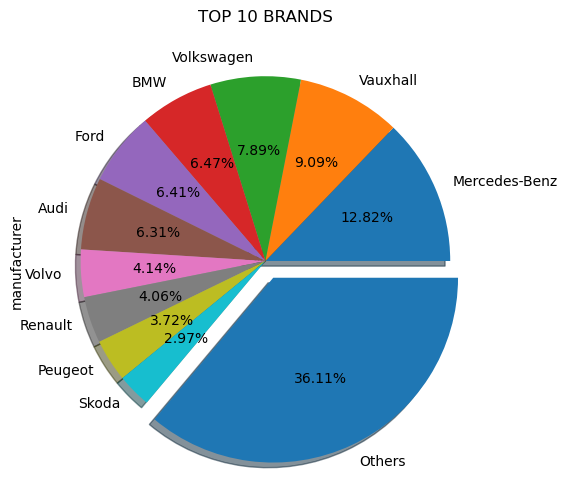

In [73]:
# n.b., i termini "manufacturer" e "brand" sono utilizzati come sinonimi
print("[" + str(uk_emissions["manufacturer"].nunique()) \
      + "] different manufacturers and ["               \
      + str(uk_emissions["manufacturer"].count())       \
      + "] total cars are registered")
manufacturers = uk_emissions["manufacturer"].value_counts()
majority_brands = manufacturers[:10]
minority_brands = manufacturers[10:]
# oppure raggruppando i brand che rappresentano meno del 5%
# minority_brands_perc = manufacturers[manufacturers < uk_emissions["manufacturer"].count() * 5 / 100]
majority_brands["Others"] = minority_brands.sum()
my_explode = np.append(np.zeros(majority_brands.count() - 1), 0.1)
majority_brands.plot.pie(title = "TOP 10 BRANDS", explode = my_explode, shadow = True, autopct = "%.2f%%", figsize=(6, 6));

In [74]:
print("OTHERS: 11th to 62nd brand in descending order of popularity:\n")
percentages = minority_brands.to_numpy() * 100 / uk_emissions["manufacturer"].count()
list_of_series = [minority_brands.index.values, minority_brands.values, percentages]
minority_df = pd.DataFrame({"manufacturer"  : minority_brands.index.values, 
                            "# occurrences" : minority_brands.values,
                            "percentage"    : percentages})
n_brands = uk_emissions["manufacturer"].nunique()
minority_df.index = range(11, n_brands + 1)
print(minority_df)

OTHERS: 11th to 62nd brand in descending order of popularity:

            manufacturer  # occurrences  percentage
11                 Honda           1222    2.685065
12               Citroen           1139    2.502692
13                  Saab            902    1.981938
14                Toyota            868    1.907231
15            Mitsubishi            767    1.685307
16                   Kia            721    1.584232
17                  Seat            710    1.560062
18                  Fiat            702    1.542484
19                Nissan            666    1.463382
20               Hyundai            641    1.408451
21                 Mazda            635    1.395267
22         Chrysler Jeep            610    1.340335
23               Porsche            606    1.331546
24                Subaru            577    1.267825
25                Suzuki            531    1.166751
26        MG Rover Group            470    1.032717
27            Alfa Romeo            465    1.021731
2

Manufacturers left after screening: [10]


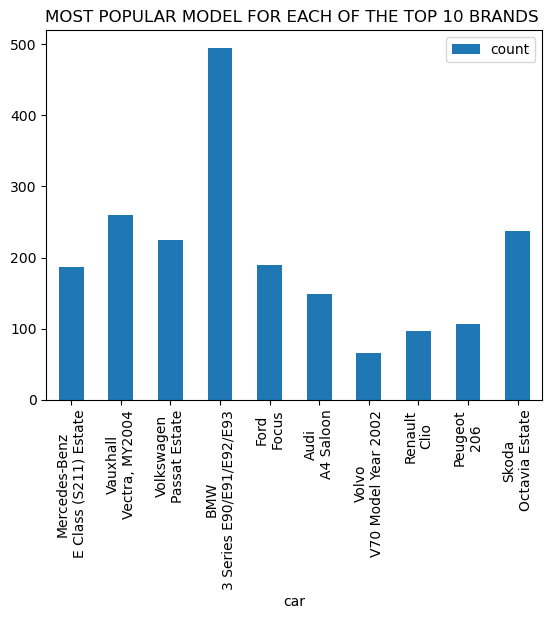

In [75]:
# ISTOGRAMMA 1 => modello più presente nei TOP 10 brand (spiegare motore o trasmissione differente)
brands_and_models = uk_emissions[["manufacturer", "model"]].copy()
brands_and_models = brands_and_models[brands_and_models.manufacturer.isin(majority_brands.index)]
print("Manufacturers left after screening: [" + str(brands_and_models.manufacturer.nunique()) + "]")
majority_brands = majority_brands.drop("Others")
brands_and_models = brands_and_models.value_counts(["manufacturer", "model"]) \
        .reset_index(name = "count")                                          \
        .sort_values(["count"], ascending = False)                            \
        .drop_duplicates(["manufacturer"])                                    \
        .set_index(["manufacturer"])                                          \
        .reindex(majority_brands.index) # ri-ordiniamo secondo la classifica dei brand stilata in precedenza
brands_and_models["car"] = brands_and_models.index + "\n" + brands_and_models["model"] # concateniamo le stringhe
brands_and_models.plot.bar(title = "MOST POPULAR MODEL FOR EACH OF THE TOP 10 BRANDS ", x = "car", y = "count");

In [76]:
# MEDIA & VALORI DISTINTI => MEDIA # DI MOTORI ALTERNATIVI × 1 MODELLO
# attenzione a modelli con stesso nome in due brand diversi !!! ignoriamo le differenze in trasmissione
n_cars = len(uk_emissions[["manufacturer", "model", "description"]].copy().drop_duplicates())
n_models = len(uk_emissions[["manufacturer", "model"]].copy().drop_duplicates())
n_brands = len(uk_emissions[["manufacturer"]].copy().drop_duplicates())
print("Average number of engine variants per model: [{:.2f}]".format(n_cars / n_models))
print("Average number of models per manufacturer:  [{:.2f}]".format(n_models / n_brands))

Average number of engine variants per model: [9.85]
Average number of models per manufacturer:  [43.05]


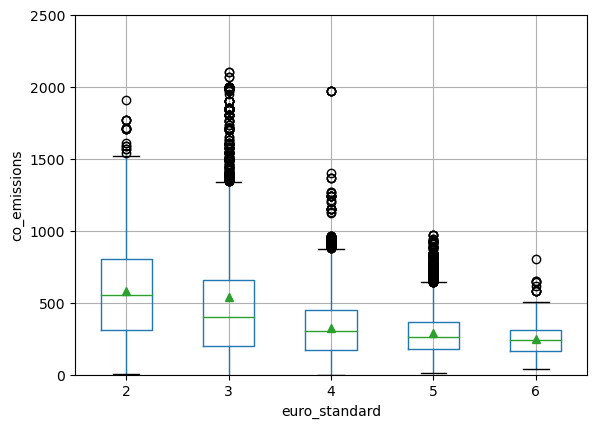

In [124]:
# QUARTILI => C0 EMISSIONS (Monossido di carbonio) X EURO
quartiles_first = uk_emissions.boxplot(column = "co_emissions", by = "euro_standard", showmeans = True);
quartiles_first.set_ylabel("co_emissions");
quartiles_first.set_title("");
plt.ylim(0, 2500);
plt.suptitle("");

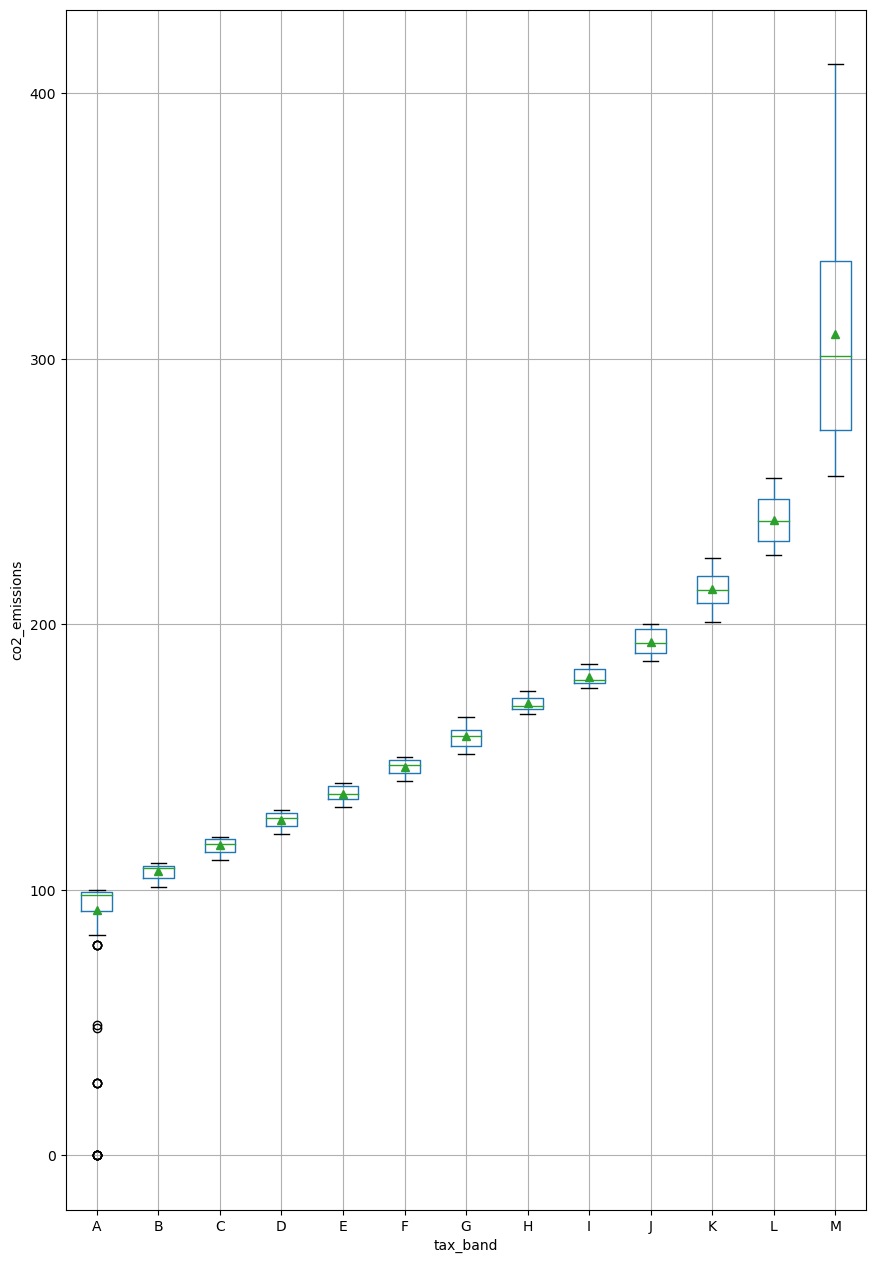

In [122]:
# QUARTILI => C02 EMISSIONS X TAX_BAND
quartiles_second = uk_emissions.boxplot(column = "co2", by = "tax_band", showmeans=True, figsize = (10, 16));
quartiles_second.set_ylabel("co2_emissions");
quartiles_second.set_title("");
plt.suptitle("");

In [78]:
# DISPERSIONE & INDICI CORRELAZIONE => ANNO & NOX_EMISSIONS
# uk_emissions.plot.scatter("year", "nox_emissions", s=7, c="red");

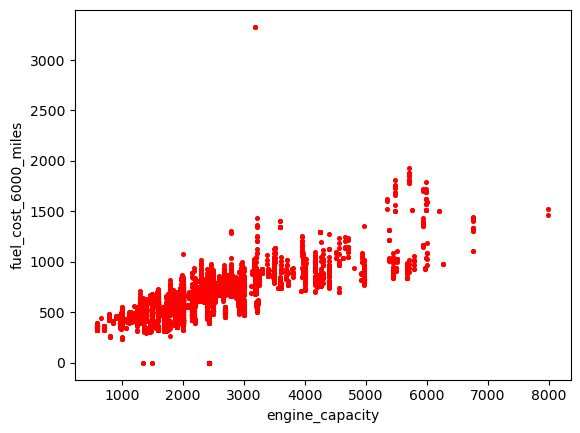

In [20]:
# DISPERSIONE & INDICI CORRELAZIONE => ENGINE_CAPACITY & FUEL_COST
uk_emissions.plot.scatter("engine_capacity", "fuel_cost_6000_miles", s=7, c="red");

# Esplorazione del dataset `spain_emissions`

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO2 emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimio e massimo di emissioni di CO2 per km percorso.

In [12]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

emissions_min_gCO2_km    True
emissions_max_gCO2_km    True
dtype: bool

Come era previdibile, tutti i valori delle emissioni di CO2 per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di C02 per veicoli a motore termico.

In [13]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)

Il dataset contiene tre colonne che rispettivamente indicano le tre dimensioni del motore, ovvero lunghezza, larghezza e altezza in millimetri. Queste tre colonne potrebbero essere delle feature molto importanti per il modello. Quindi è necessario mantenerle nel dataset per motivi di compatibilità con gli altri dataset in una nuova colonna `engine_capacity`, il volume in millimetri cubi, dato dal prodotto delle tre colonne.


In [14]:
spain_emissions["length_mm"] * spain_emissions["width_mm"] * spain_emissions["height_mm"]

31         8842907700
32         8842907700
33         8842907700
34         8842907700
35         8842907700
             ...     
17403     97916000000
17404    124800000000
17405    124800000000
17406     90636000000
17407     90636000000
Length: 15107, dtype: int64

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi, potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'**unione** degli **attributi**, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da (a seconda che le colonne siano di tipo categorico o numerico):
- media
- moda
- mediana

In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano saltuariamente sotto denominazioni diverse, ed a loro volta i valori da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico). 







## Omogeneizzazione di `uk_emissions`

Eliminare le tasse poichè gli altri dataset non le hanno e in quanto le tasse sono calcolate in base agli altri attributi, 